In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install ace-tools

In [3]:

!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [4]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt


In [6]:
# ✅ Load ERCOT energy demand data
ercot_data = pd.read_excel("/content/drive/MyDrive/Bushrasa project/DataSet/LoadTexasERCOT.xlsx", engine="openpyxl")

# ✅ Convert datetime column automatically
ercot_data["Hour_End"] = pd.to_datetime(ercot_data["Hour_End"], errors='coerce')

# ✅ Set datetime as index
ercot_data.set_index("Hour_End", inplace=True)

# ✅ Load & Process Weather Data
def load_weather_data(file_path):
    df = pd.read_excel(file_path, engine="openpyxl")
    df["Timestamp"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute"]])
    df.set_index("Timestamp", inplace=True)
    df.drop(columns=["Year", "Month", "Day", "Hour", "Minute"], inplace=True)
    return df

weather1 = load_weather_data("/content/drive/MyDrive/Bushrasa project/DataSet/WeatherStation1.xlsx")
weather2 = load_weather_data("/content/drive/MyDrive/Bushrasa project/DataSet/WeatherStation2.xlsx")
weather3 = load_weather_data("/content/drive/MyDrive/Bushrasa project/DataSet/WeatherStation3.xlsx")

# ✅ Merge Weather Data (Averaging)
weather_data = pd.concat([weather1, weather2, weather3]).groupby("Timestamp").mean()

# ✅ Align Data Timestamps
ercot_data.index = ercot_data.index.floor('h')
weather_data.index = weather_data.index.floor('h')

# ✅ Ensure Matching Time Ranges
common_start = max(ercot_data.index.min(), weather_data.index.min())
common_end = min(ercot_data.index.max(), weather_data.index.max())
ercot_data = ercot_data[(ercot_data.index >= common_start) & (ercot_data.index <= common_end)]
weather_data = weather_data[(weather_data.index >= common_start) & (weather_data.index <= common_end)]

# ✅ Merge Data
merged_data = ercot_data.merge(weather_data, left_index=True, right_index=True, how="inner")
print("✅ Data successfully merged!")


✅ Data successfully merged!


In [7]:
merged_data.head()


,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT,Relative Humidity,Temperature,Pressure
2012-01-01 01:00:00,7748.160500,878.438488,1289.746813,652.153054,8648.989316,2105.379142,4162.162310,849.000892,26334.030515,50.063333,5.333333,953.333333
2012-01-01 01:00:00,7559.728089,839.092904,1294.272245,643.483530,8553.212708,2047.755534,4070.416593,845.097363,25853.058967,50.063333,5.333333,953.333333
2012-01-01 03:00:00,7337.789042,817.995707,1296.491345,631.940923,8461.317967,1961.909818,3946.994332,840.902848,25295.341984,62.153333,2.333333,960.000000
2012-01-01 04:00:00,7161.895539,814.967883,1297.417294,631.428520,8438.693857,1893.148232,3884.929253,845.452257,24967.932835,69.886667,2.000000,963.333333
2012-01-01 04:00:00,6984.460743,843.952579,1309.534911,640.892563,8565.433348,1867.358425,3911.610238,862.369386,24985.612193,69.886667,2.000000,963.333333


In [8]:
# ✅ Ensure Date Features Exist
merged_data["Hour"] = merged_data.index.hour
merged_data["Day"] = merged_data.index.day
merged_data["Month"] = merged_data.index.month


In [9]:
# ✅ Fill NaN values with column means
merged_data.fillna(merged_data.mean(), inplace=True)

# ✅ Select Features for Training
selected_features = ["ERCOT", "Temperature", "Relative Humidity", "Pressure", "Hour", "Day", "Month"]

# ✅ Apply Standard Scaling
scaler = StandardScaler()
merged_data[selected_features] = scaler.fit_transform(merged_data[selected_features])

print("✅ Data preprocessing completed!")


✅ Data preprocessing completed!


In [10]:
SEQ_LENGTH = 24  # Look back 24 hours

def create_sequences(data, seq_length=SEQ_LENGTH):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # Features except target
        y.append(data[i + seq_length, -1])  # Target (energy demand)
    return np.array(X), np.array(y)

# ✅ Convert DataFrame to NumPy Array
data_array = merged_data[selected_features].values

# ✅ Create Sequences
X, Y = create_sequences(data_array)

# ✅ Train-Test Split
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

print("✅ Sequence generation completed!")


✅ Sequence generation completed!


In [11]:
def build_gru_model(hp):
    model = Sequential([
        Input(shape=(24, X_train.shape[2])),

        GRU(hp.Int("units1", min_value=64, max_value=512, step=64), return_sequences=True),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(hp.Float("dropout1", min_value=0.1, max_value=0.5, step=0.1)),

        GRU(hp.Int("units2", min_value=32, max_value=256, step=32)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(hp.Float("dropout2", min_value=0.1, max_value=0.5, step=0.1)),

        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="LOG")),
        loss=Huber(delta=1.0),
        metrics=['mae']
    )

    return model


In [12]:
tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_mae',
    max_trials=10,
    directory='/mnt/data/gru_tuning',
    project_name='gru_energy_forecasting_v2'
)

# ✅ Run tuning
tuner.search(X_train, Y_train, epochs=30, batch_size=64, validation_data=(X_test, Y_test))


Trial 10 Complete [00h 03m 54s]
val_mae: 0.5506420731544495

Best val_mae So Far: 0.44190773367881775
Total elapsed time: 00h 37m 05s


In [13]:
# ✅ Retrieve Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# ✅ Train Best Model
history = best_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

# ✅ Save the Model
best_model.save("/content/drive/MyDrive/Bushrasa project/best_gru_model.h5")
print("✅ Best model trained and saved successfully!")


Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.4811 - mae: 0.8504 - val_loss: 0.4052 - val_mae: 0.7643
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3577 - mae: 0.6921 - val_loss: 0.3814 - val_mae: 0.7299
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3122 - mae: 0.6267 - val_loss: 0.2933 - val_mae: 0.6199
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2729 - mae: 0.5698 - val_loss: 0.3382 - val_mae: 0.6536
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.2240 - mae: 0.5005 - val_loss: 0.2812 - val_mae: 0.5650
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1874 - mae: 0.4462 - val_loss: 0.2581 - val_mae: 0.5258
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1558 - mae: 0.3962 - val_loss: 0.3141 - val_mae: 0.5819
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1266 - mae: 0.3501 - val_loss: 0.2575 - val_mae: 0.5135
Epoch 9/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13m

✅ Best model trained and saved successfully!


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
🚀 Improved Model Performance:
✅ MAE: 0.4782907913988354
✅ RMSE: 0.9161971660687388
✅ R² Score: -0.3067689585690587


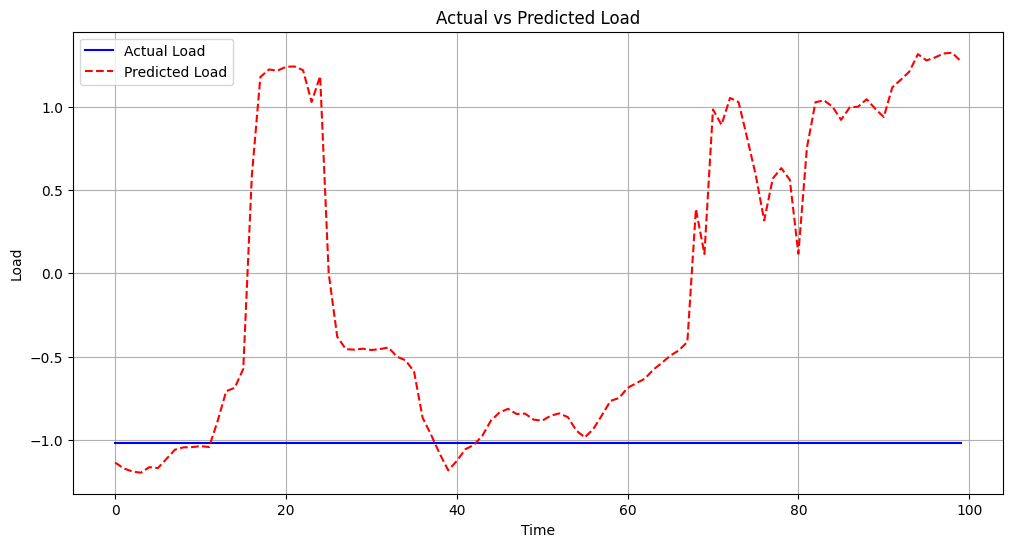

In [14]:
# ✅ Generate Predictions
predictions = best_model.predict(X_test)

# ✅ Evaluate Performance
mae = mean_absolute_error(Y_test, predictions)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
r2 = r2_score(Y_test, predictions)

print(f"🚀 Improved Model Performance:")
print(f"✅ MAE: {mae}")
print(f"✅ RMSE: {rmse}")
print(f"✅ R² Score: {r2}")

# ✅ Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(Y_test[:100], label="Actual Load", color="blue")
plt.plot(predictions[:100], label="Predicted Load", color="red", linestyle="--")
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual vs Predicted Load')
plt.legend()
plt.grid(True)
plt.show()
